# Clasificador polen (Telmu) a partir de una red pre-entrenada:

### GPU disponible:

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Modelo Inception:

In [2]:
import sys
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import  Convolution2D, MaxPooling2D, Dense, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K
from keras import applications
K.clear_session()

Using TensorFlow backend.


Se carga el modelo InceptionResNetV2: 

keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

Este modelo contiene los pesos obtenidos con el pre-entrenamiento en ImageNet. Por defecto, establece una imagen de entrada de 299x299.

In [3]:
baseModel = applications.inception_resnet_v2.InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(299, 299, 3))#Cargamos la red
baseModel.summary()#Muestra el contenido de la red.

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_____________________________________

activation_184 (Activation)     (None, 8, 8, 192)    0           batch_normalization_184[0][0]    
__________________________________________________________________________________________________
activation_187 (Activation)     (None, 8, 8, 256)    0           batch_normalization_187[0][0]    
__________________________________________________________________________________________________
block8_6_mixed (Concatenate)    (None, 8, 8, 448)    0           activation_184[0][0]             
                                                                 activation_187[0][0]             
__________________________________________________________________________________________________
block8_6_conv (Conv2D)          (None, 8, 8, 2080)   933920      block8_6_mixed[0][0]             
__________________________________________________________________________________________________
block8_6 (Lambda)               (None, 8, 8, 2080)   0           block8_5_ac[0][0]                
          

Se ha pasado como argumento include_top=False. La red VGG16 que aporta keras contiene por defecto una última capa de predicción de mil neuronas (para clasificar mil clases diferentes). La red que se busca solo clasificará dos clases diferentes. Con include_top=False se elimina esta última capa. En la siguiente línea de código se carga la red al completo:

### Modificación de la última capa:

Se diseña la capa de salida para realizar la clasificación. Constará de:

Capa GlobalAveragePooling2D.

Capa tipo Dense de 1000 neuronas y activación rectificador (relu)

In [4]:
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(598, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# add a global spatial average pooling layer
#x = InceptionResNetV2.output
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(800, activation='relu')(x)
#To reduce overfitting...
#x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 3 classes
#predictions = Dense(2, activation='softmax')(x)
#model = Model(inputs=InceptionResNetV2.input, outputs=predictions)

model = Model(inputs=baseModel.input, outputs=headModel)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
model.layers

### Congelación de capas:

Se ha cargado la red pre-entrenada InceptionResNetV2, con los pesos de Imagenet. De esta forma las capas convolucionales y pooling que la forman actuarán como diferenciadoras de características, que serán usadas por la capa final que se ha incluido para realizar la clasificación.

Por tanto, se va a usar una red que ya ha 'aprendido' a clasificar en otros problemas, y se va a adaptar para el problema que aquí se trata (TRANSFER LEARNING).

Es por esto que no es necesario entrenar todas las capas de la red, y solo se entrenarán las 3 capas que se han añadido, congelando las demás.

In [6]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed_5b
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 conv2d_13
51 conv2d_15
52 conv2d_18
53 batch_normalization_13
54 batch_normalization_15
55 batch_normalization

625 conv2d_167
626 batch_normalization_164
627 batch_normalization_167
628 activation_164
629 activation_167
630 block8_1_mixed
631 block8_1_conv
632 block8_1
633 block8_1_ac
634 conv2d_169
635 batch_normalization_169
636 activation_169
637 conv2d_170
638 batch_normalization_170
639 activation_170
640 conv2d_168
641 conv2d_171
642 batch_normalization_168
643 batch_normalization_171
644 activation_168
645 activation_171
646 block8_2_mixed
647 block8_2_conv
648 block8_2
649 block8_2_ac
650 conv2d_173
651 batch_normalization_173
652 activation_173
653 conv2d_174
654 batch_normalization_174
655 activation_174
656 conv2d_172
657 conv2d_175
658 batch_normalization_172
659 batch_normalization_175
660 activation_172
661 activation_175
662 block8_3_mixed
663 block8_3_conv
664 block8_3
665 block8_3_ac
666 conv2d_177
667 batch_normalization_177
668 activation_177
669 conv2d_178
670 batch_normalization_178
671 activation_178
672 conv2d_176
673 conv2d_179
674 batch_normalization_176
675 batch_norma

In [7]:
#for layer in model.layers[:780]:
#   layer.trainable = False
#for layer in model.layers[780:]:
#   layer.trainable = True
for layer in baseModel.layers:
    layer.trainable = False

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

conv2d_130 (Conv2D)             (None, 17, 17, 128)  139264      block17_13_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_130 (BatchN (None, 17, 17, 128)  384         conv2d_130[0][0]                 
__________________________________________________________________________________________________
activation_130 (Activation)     (None, 17, 17, 128)  0           batch_normalization_130[0][0]    
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 17, 17, 160)  143360      activation_130[0][0]             
__________________________________________________________________________________________________
batch_normalization_131 (BatchN (None, 17, 17, 160)  480         conv2d_131[0][0]                 
__________________________________________________________________________________________________
activation

activation_160 (Activation)     (None, 8, 8, 288)    0           batch_normalization_160[0][0]    
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 8, 8, 320)    0           batch_normalization_163[0][0]    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 8, 8, 1088)   0           block17_20_ac[0][0]              
__________________________________________________________________________________________________
mixed_7a (Concatenate)          (None, 8, 8, 2080)   0           activation_158[0][0]             
                                                                 activation_160[0][0]             
                                                                 activation_163[0][0]             
                                                                 max_pooling2d_4[0][0]            
__________

### Tratamiento de las imágenes:

Se necesita adaptar el conjunto de imágenes para poder ser tratado por el modelo. Para ello se van a usar las funciones flow_from_directory() y ImageDataGenerator().

In [9]:
#Se almacenan en variables los directorios en los que se encuentran las imágenes
data_entrenamiento = './data_polen/entrenamiento'
data_validacion = './data_polen/validacion'

#Parámetros importantes:
epocas=90
longitud, altura = 299, 299
batch_size = 16 #Imágenes a procesar en cada paso
pasos = 10
clases = 3
lr = 1e-4 #Learning rate
momentum = 0.9

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')

Con la función flow_from_directory() se pre-procesan las imágenes que se encuentran en los directorios previamente declarados. Además se le puede pasar como parámetros el tamaño al que se redimensionan las imágenes, o el algoritmo de interpolación.

keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

Gracias a la función ImageDataGenerator() se aplica al set de entrenamiento mecanismos de DATA ARGUMENTATION como inclinar, hacer zoom o invertir las imágenes.

In [10]:
###Procesamiento del conjunto de entrenamieto:
entrenamiento_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, #Inclina las imágenes
    zoom_range=0.2, #Zoom a algunas imágenes
    horizontal_flip=True) #Invierte imágenes para distinguir direcionalidad

###Procesamiento del conjunto de validación:
#No es necesario inclinar, hacer zoom ni invertir las imágenes.
test_datagen = ImageDataGenerator(rescale=1. / 255)

###Generación del conjunto de entrenamieto:
entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical') #Se busca una clasificación categórica

###Generación del conjunto de validación:
validacion_generador = test_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')

print(entrenamiento_generador.class_indices)

Found 180 images belonging to 3 classes.
Found 54 images belonging to 3 classes.
{'Muestra1': 0, 'Muestra10': 1, 'Muestra6': 2}


### Definición del modelo CNN: función pérdida y optimizador:

In [11]:
opt = optimizers.SGD(lr=lr, momentum=momentum)
model.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

### Entrenamiento del modelo:

fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

In [12]:
H = model.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=len(entrenamiento_generador),
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=len(validacion_generador))

Instructions for updating:
Use tf.cast instead.
Epoch 1/90
12/12 [==============================] - 26s 2s/step - loss: 1.1431 - acc: 0.3115 - val_loss: 1.2307 - val_acc: 0.2778
Epoch 2/90
12/12 [==============================] - 10s 845ms/step - loss: 1.1398 - acc: 0.2670 - val_loss: 1.2247 - val_acc: 0.2778
Epoch 3/90
12/12 [==============================] - 10s 846ms/step - loss: 1.0826 - acc: 0.3691 - val_loss: 1.2176 - val_acc: 0.2593
Epoch 4/90
12/12 [==============================] - 16s 1s/step - loss: 1.0948 - acc: 0.3691 - val_loss: 1.2168 - val_acc: 0.2593
Epoch 5/90
12/12 [==============================] - 10s 847ms/step - loss: 1.1038 - acc: 0.3350 - val_loss: 1.2135 - val_acc: 0.2593
Epoch 6/90
12/12 [==============================] - 10s 851ms/step - loss: 1.0875 - acc: 0.3756 - val_loss: 1.2204 - val_acc: 0.2778
Epoch 7/90
12/12 [==============================] - 10s 852ms/step - loss: 1.0808 - acc: 0.4150 - val_loss: 1.2267 - val_acc: 0.2593
Epoch 8/90
12/12 [=========

### Gráficas con resultados del entrenamiento batch_size 16:

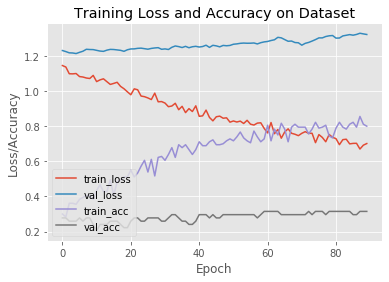

In [14]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
N = epocas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")#Se guarda la gráfica en disco

### Cálculo de la función pérdida:

El método evaluate_generator(generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0) se encarga de calcular la función de pérdida dados unos datos de entrada y el nivel de aciertos del modelo para una muestra dada.

In [15]:
score = model.evaluate_generator(validacion_generador, steps=pasos, verbose=1)
print('Test accuracy:', score[1])
print('Loss:', score[0])

10/10 [==============================] - 6s 645ms/step
Test accuracy: 0.30769230883855087
Loss: 1.3367773239429181


### Guardar el modelo entrenado:

Para no tener que entrenar la red neuronal creada cada vez que se quiera usar, se crea un archivo donde se guarda el modelo creado, y otro donde se guardan los pesos obtenidos para las neuronas después del entranmiento.

In [ ]:
import os 
dir = './InceptionResNetV2_OliGram_Prueba/'
if not os.path.exists(dir):
    os.mkdir(dir)
model.save('./InceptionResNetV2_OliGram_Prueba/modelo_InceptionResNetV2.h5')#Se guarda la estructura de la cnn
model.save_weights('./InceptionResNetV2_OliGram_Prueba/pesos_InceptionResNetV2.h5')#Se guardan los pesos de la cnn

### Pruebas de clasificación:

In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

La función load_image() transforma de forma interna las imágenes, tomando como argumento las dimensiones que admiten las arquitecturas implementadas y un método de interpolación. Se recomienda usar métodos de interpolación como bicubic o lanczos, frente a nearest que viene por defecto.

In [ ]:
###Función predicción:
def predict(file):
  x = load_img(file, target_size=(altura, longitud))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0) #Zero mean pre-processing, normalize data.
  array = model.predict(x)
  print(array)  
  result = array[0]
  print(result)
  answer = np.argmax(result)
  print(answer)  
  if answer == 0:
    print("pred: Gramineas")
  elif answer == 1:
    print("pred: Olivo")
  return answer

In [ ]:
x = load_img('graminea1.jpg', target_size=(altura, longitud))
x = img_to_array(x)
x = np.expand_dims(x, axis=0)
model.predict(x)